In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy.stats import linregress

from astropy import units as u
from astropy import constants as c
from astropy.time import Time

from sunpy.data import cache
from sunpy.coordinates import spice, frames
from sunpy.net import Fido
from sunpy.net.cdaweb import get_datasets
from sunpy.net.cdaweb import get_observatory_groups
from sunpy.time import parse_time
from sunpy.net import attrs as a
from sunpy.timeseries import TimeSeries

from sw_functions import download_sc_dataset, get_trajectory

/Users/nathan/.pyenv/versions/3.13.7/envs/sun_capstone/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get Mag / SW data
psp_mag, solo_mag = pd.read_pickle('data/psp_mag_rtn_1hour'), pd.read_pickle('data/solo_mag_rtn_1hour')
psp_sw, solo_sw = pd.read_pickle('data/psp_sweap_l3i_1hour'), pd.read_pickle('data/solo_swa_pas_grnd_mom_l2_1hour')

# Compute trajectory data
psp_traj_mag, psp_obstime_mag = get_trajectory(psp_mag, 'psp')
psp_traj_sw, psp_obstime_sw = get_trajectory(psp_sw, 'psp')

solo_traj_mag, solo_obstime_mag = get_trajectory(solo_mag, 'solo')
solo_traj_sw, solo_obstime_sw = get_trajectory(solo_sw, 'solo')

In [34]:
psp = psp_sw.join(psp_mag)
solo = solo_mag.join(solo_sw)

psp['Distance'] = psp_traj_sw.radius.to('AU').value
solo['Distance'] = solo_traj_mag.radius.to('AU').value

In [4]:
# Combine Datasets
joined_mag, joined_sw = pd.concat([psp_mag, solo_mag]), pd.concat([psp_sw, solo_sw])

# Combine Distances
sc_dist_mag, sc_dist_sw = [*psp_traj_mag.radius.to('AU').value, *solo_traj_mag.radius.to('AU').value], [*psp_traj_sw.radius.to('AU').value, *solo_traj_sw.radius.to('AU').value]
joined_dist_mag, joined_dist_sw = pd.DataFrame({'Sun Distance' : sc_dist_mag}), pd.DataFrame({'Sun Distance' : sc_dist_sw})

# MinMax values for mag and sw data
joined_mag_max, joined_mag_min = joined_mag.max(), joined_mag.min()
joined_sw_max, joined_sw_min = joined_sw.max(), joined_sw.min()

In [108]:
def create_ds(sc, year=None):
    """Create PSP or SolO complete dataset, global or by year.
    """
    if sc == 'psp':
        ds = psp_sw.join(psp_mag)
        ds['Distance'] = psp_traj_sw.radius.to('AU').value
        # Slice during Solo's Mission duration
        start, end = '2020-4-15', '2025-5-31'
        ds = ds[(ds.index >= start) & (ds.index <= end)]

    if sc == 'solo':
        ds = solo_sw.join(solo_mag)
        ds['Distance'] = solo_traj_sw.radius.to('AU').value

    if year:
        ds = ds[ds.index.year == year]

    return ds

def bin_distance(ds):
    """Get SC params median and stdev binned by distance from a dataset.
    """
    # Create bins
    bins = np.arange(0, 1.1, 0.1)
    ds['distance_bin'] = pd.cut(ds['Distance'], bins)

    # Group by distance bins and compute median, min, max
    sc_dist_med = ds.groupby('distance_bin').median().reset_index()
    sc_dist_std = ds.groupby('distance_bin').std().reset_index()

    return sc_dist_med, sc_dist_std

In [118]:
psp_min_med == psp_max_med

,distance_bin,DQF_0,DQF_1,DQF_2,DQF_3,DQF_4,DQF_5,DQF_6,DQF_7,DQF_8,...,wp_moment_deltalow,Vp,Tp,Np,B_r,B_t,B_n,psp_fld_l2_quality_flags,total_B,Distance
0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,True,True,True,True,True,True
9,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Time Histograms

## Global

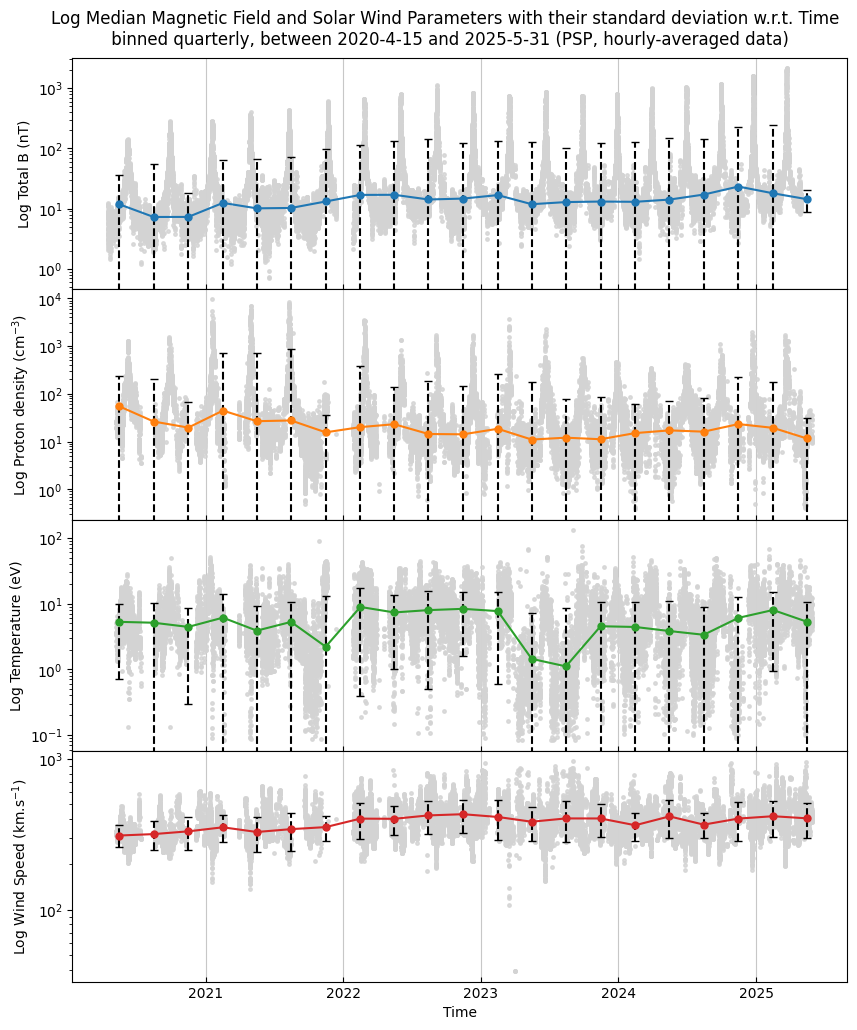

In [ ]:
psp = create_ds('psp')

# Time distributions
psp['quarter'] = psp.index.to_period('Q')

psp_time_med = psp.groupby('quarter').median().reset_index()
psp_time_std = psp.groupby('quarter').std().reset_index()

colors = ['tab:blue','tab:orange','tab:green','tab:red','m','y']

fig, ax = plt.subplots(4, sharex=True, dpi=100, figsize=(10,12))

ax[0].set_ylabel('Log Total B (nT)')
ax[1].set_ylabel('Log Proton density (cm$^{-3}$)')
ax[2].set_ylabel('Log Temperature (eV)')
ax[3].set_ylabel('Log Wind Speed (km.s$^{-1}$)')
ax[3].set_xlabel('Time')

for aa, data, color in zip(ax, ['total_B', 'Np', 'Tp', 'Vp'], colors):
    # Plot Data
    aa.plot(psp.index, psp[f'{data}'], '.', c='lightgrey', ms=5, alpha=.8)

    # Stdev lines
    aa.vlines(psp_time_med['quarter'].dt.to_timestamp()+pd.Timedelta(days=45), psp_time_med[f'{data}']-psp_time_std[f'{data}'], psp_time_med[f'{data}']+psp_time_std[f'{data}'], 'k', ls='--')

    # Plot Median
    aa.plot(psp_time_med['quarter'].dt.to_timestamp()+pd.Timedelta(days=45), psp_time_med[f'{data}'], '-o', c=color, ms=5)

    # Plot stdev bounds
    aa.plot(psp_time_med['quarter'].dt.to_timestamp()+pd.Timedelta(days=45), psp_time_med[f'{data}']-psp_time_std[f'{data}'], 'k_')
    aa.plot(psp_time_med['quarter'].dt.to_timestamp()+pd.Timedelta(days=45), psp_time_med[f'{data}']+psp_time_std[f'{data}'], 'k_')

    # Add grid, inwards ticks
    aa.tick_params(axis='x', direction='in', which='both')
    aa.grid('.', alpha=0.7, axis='x')
    aa.set_yscale('log')

plt.subplots_adjust(hspace=0)

fig.suptitle(f'Log Median Magnetic Field and Solar Wind Parameters with their standard deviation w.r.t. Time \n binned quarterly, between {start} and {end} (PSP, hourly-averaged data)', y=0.92)

plt.savefig(f'plots/psp_time_median_params_global.png')

## Yearly

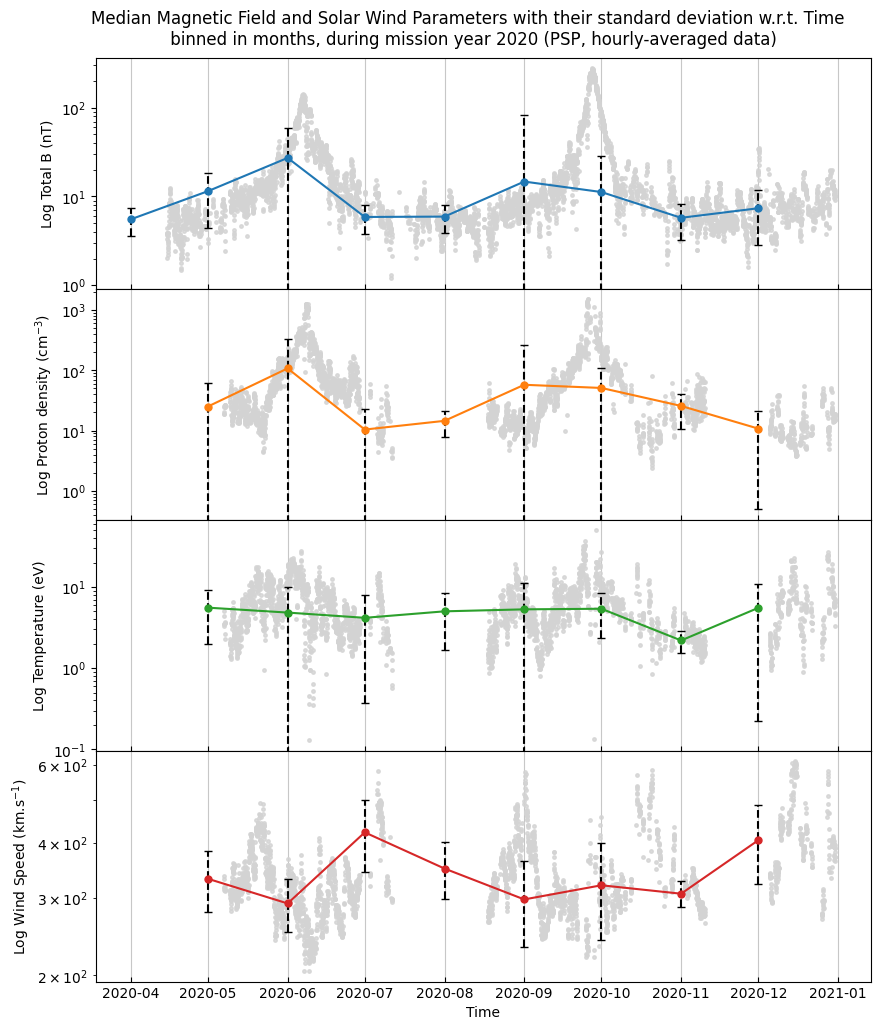

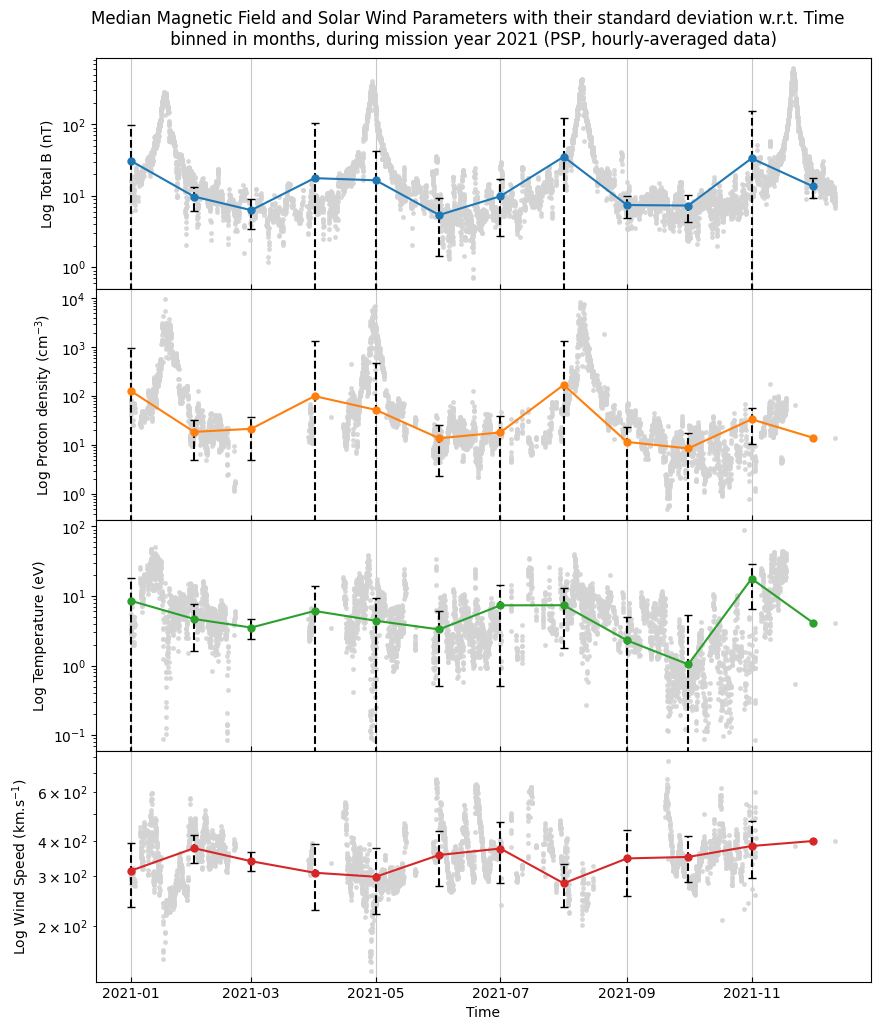

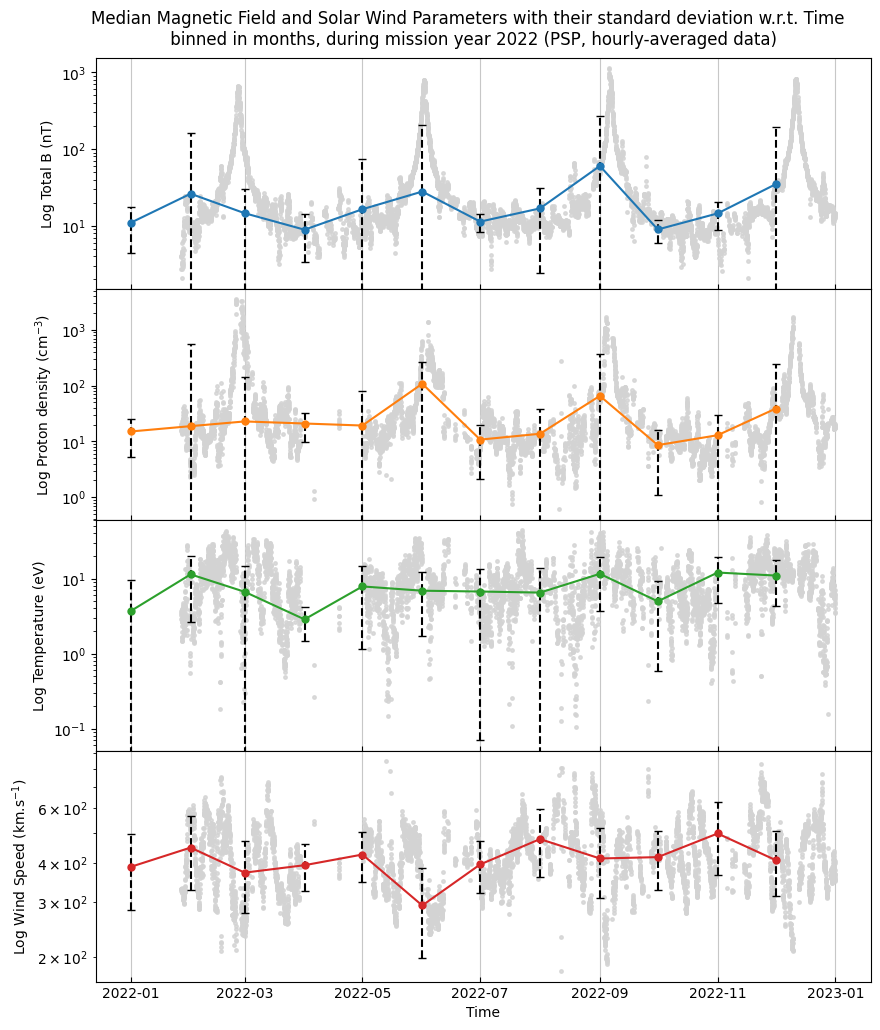

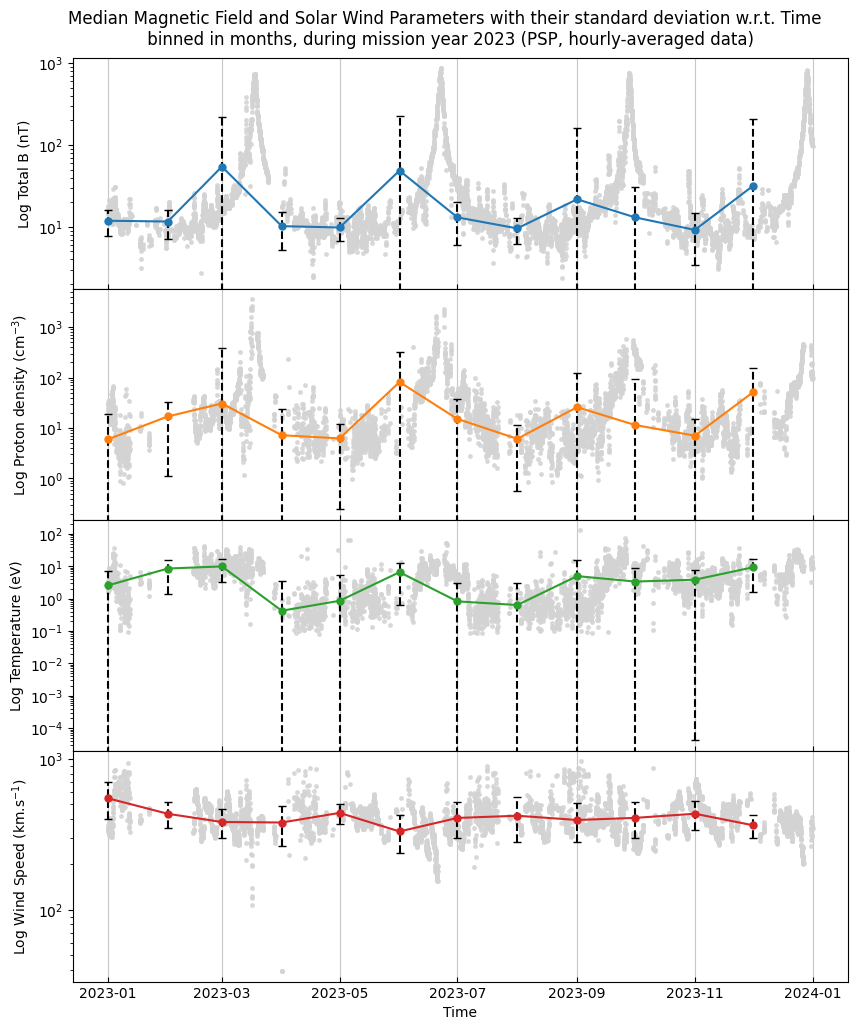

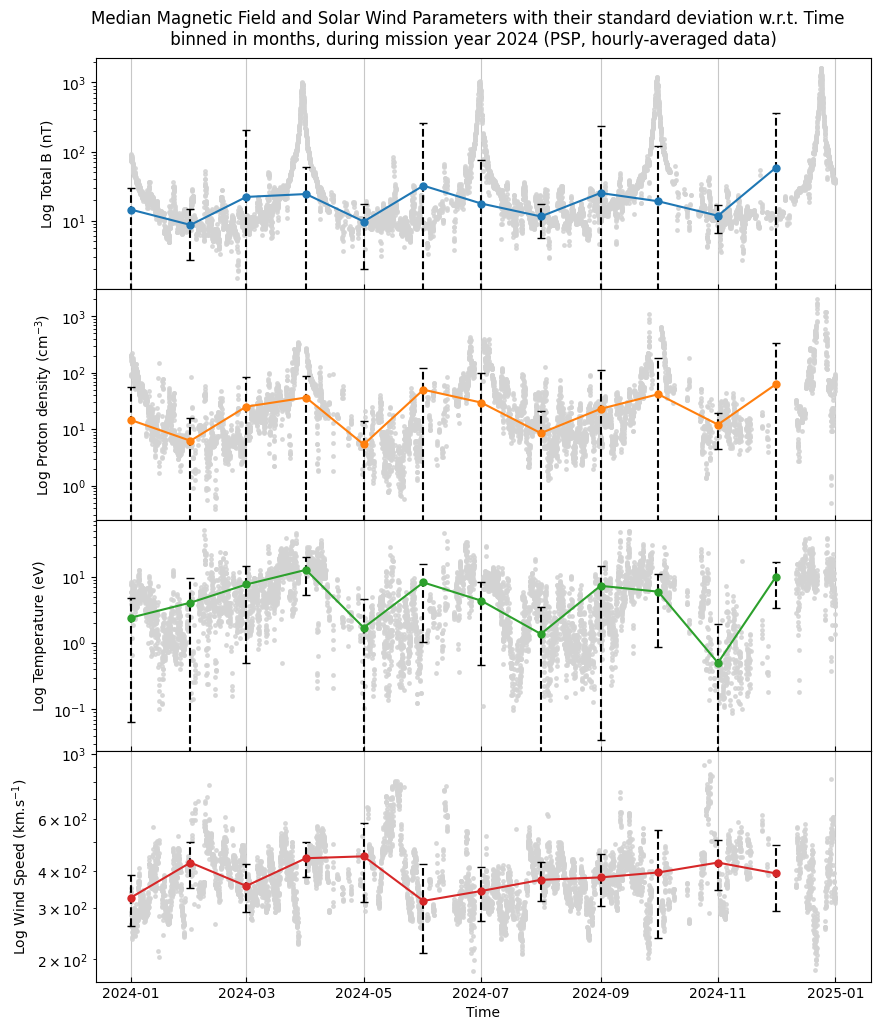

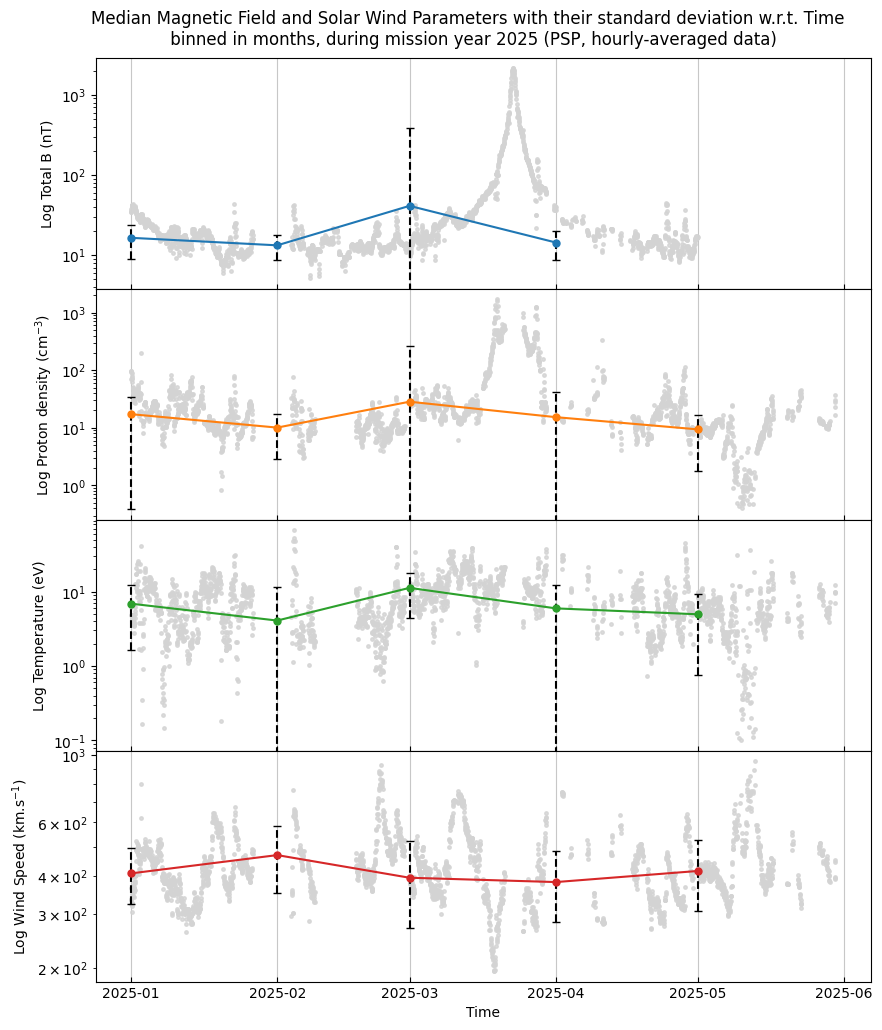

In [ ]:
for year in np.arange(2020, 2026):
    # Create dataset
    psp = create_ds('psp', year)

    # Time distributions
    psp['month'] = psp.index.to_period('M')

    psp_time_med = psp.groupby('month').median().reset_index()
    psp_time_std = psp.groupby('month').std().reset_index()

    colors = ['tab:blue','tab:orange','tab:green','tab:red','m','y']

    fig, ax = plt.subplots(4, sharex=True, dpi=100, figsize=(10,12))

    ax[0].set_ylabel('Log Total B (nT)')
    ax[1].set_ylabel('Log Proton density (cm$^{-3}$)')
    ax[2].set_ylabel('Log Temperature (eV)')
    ax[3].set_ylabel('Log Wind Speed (km.s$^{-1}$)')
    ax[3].set_xlabel('Time')

    for aa, data, color in zip(ax, ['total_B', 'Np', 'Tp', 'Vp'], colors):
        # Plot Data
        aa.plot(psp.index, psp[f'{data}'], '.', c='lightgrey', ms=5, alpha=.8)

        # Stdev lines
        aa.vlines(psp_time_med['month'].dt.to_timestamp(), psp_time_med[f'{data}']-psp_time_std[f'{data}'], psp_time_med[f'{data}']+psp_time_std[f'{data}'], 'k', ls='--')

        # Plot Median
        aa.plot(psp_time_med['month'].dt.to_timestamp(), psp_time_med[f'{data}'], '-o', c=color, ms=5)

        # Plot stdev bounds
        aa.plot(psp_time_med['month'].dt.to_timestamp(), psp_time_med[f'{data}']-psp_time_std[f'{data}'], 'k_')
        aa.plot(psp_time_med['month'].dt.to_timestamp(), psp_time_med[f'{data}']+psp_time_std[f'{data}'], 'k_')

        # Add grid, inwards ticks
        aa.tick_params(axis='x', direction='in', which='both')
        aa.grid('.', alpha=0.7, axis='x')
        aa.set_yscale('log')

    plt.subplots_adjust(hspace=0)

    fig.suptitle(f'Median Magnetic Field and Solar Wind Parameters with their standard deviation w.r.t. Time \n binned in months, during mission year {str(year)} (PSP, hourly-averaged data)', y=0.92)

    plt.savefig(f'plots/psp_time_median_params_{str(year)}.png')

# Distance Histograms

## Global

/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_44080/416628667.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sc_dist_med = ds.groupby('distance_bin').median().reset_index()
/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_44080/416628667.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sc_dist_std = ds.groupby('distance_bin').std().reset_index()
/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_44080/416628667.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curre

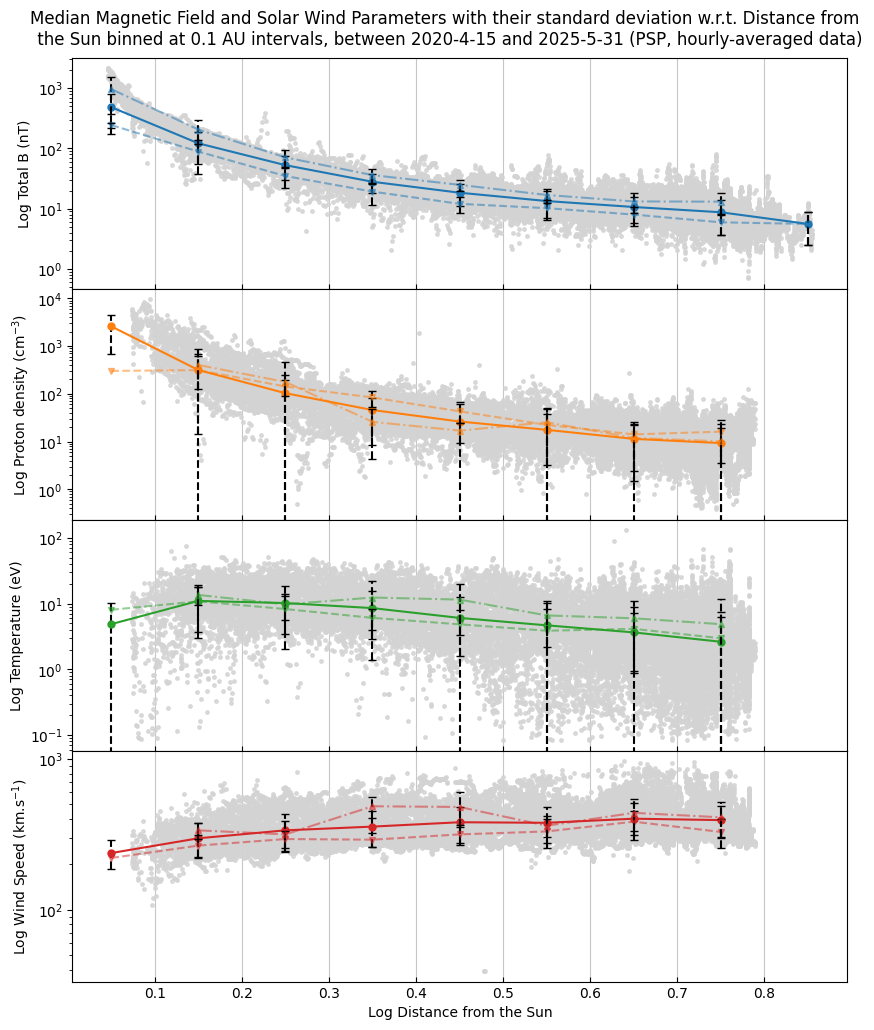

In [125]:
# Create Global Dataframe, create bins
psp = create_ds('psp')
psp_bin_med, psp_bin_std = bin_distance(psp)

# Create Solar minimum Dataframe and bins
psp_min = create_ds('psp', 2020)
psp_min_med, psp_min_std = bin_distance(psp_min)

# Create Solar maximum Dataframe and bins
psp_max = create_ds('psp', 2025)
psp_max_med, psp_max_std = bin_distance(psp_max)

# Define Colors
colors = ['tab:blue','tab:orange','tab:green','tab:red','m','y']

# Create Figure
fig, ax = plt.subplots(4, sharex=True, dpi=100, figsize=(10,12))

# Set axes labels
ax[0].set_ylabel('Log Total B (nT)')
ax[1].set_ylabel('Log Proton density (cm$^{-3}$)')
ax[2].set_ylabel('Log Temperature (eV)')
ax[3].set_ylabel('Log Wind Speed (km.s$^{-1}$)')
ax[3].set_xlabel('Log Distance from the Sun')

for aa, data, color in zip(ax, ['total_B', 'Np', 'Tp', 'Vp'], colors):
    # ALL TIMES
    # Plot Data
    aa.plot(psp['Distance'], psp[f'{data}'], '.', c='lightgrey', ms=5, alpha=.8)
    # Stdev lines
    aa.vlines(bins[:-1]+.05, psp_bin_med[f'{data}']-psp_bin_std[f'{data}'], psp_bin_med[f'{data}']+psp_bin_std[f'{data}'], 'k', ls='--')
    # Plot Median
    aa.plot(bins[:-1]+.05, psp_bin_med[f'{data}'], '-o', c=color, ms=5)
    # Plot stdev bounds
    aa.plot(bins[:-1]+.05, psp_bin_med[f'{data}']-psp_bin_std[f'{data}'], 'k_')
    aa.plot(bins[:-1]+.05, psp_bin_med[f'{data}']+psp_bin_std[f'{data}'], 'k_')

    # SOLAR MINIMUM
    # Stdev lines
    aa.vlines(bins[:-1]+.05, psp_min_med[f'{data}']-psp_min_std[f'{data}'], psp_min_med[f'{data}']+psp_min_std[f'{data}'], 'k', ls='--')
    # Plot Median
    aa.plot(bins[:-1]+.05, psp_min_med[f'{data}'], '--v', c=color, ms=5, alpha=.5)
    # Plot stdev bounds
    aa.plot(bins[:-1]+.05, psp_min_med[f'{data}']-psp_min_std[f'{data}'], 'k_')
    aa.plot(bins[:-1]+.05, psp_min_med[f'{data}']+psp_min_std[f'{data}'], 'k_')

    # SOLAR MAXIMUM
    # Stdev lines
    aa.vlines(bins[:-1]+.05, psp_max_med[f'{data}']-psp_max_std[f'{data}'], psp_max_med[f'{data}']+psp_max_std[f'{data}'], 'k', ls='--')
    # Plot Median
    aa.plot(bins[:-1]+.05, psp_max_med[f'{data}'], '-.^', c=color, ms=5, alpha=.5)
    # Plot stdev bounds
    aa.plot(bins[:-1]+.05, psp_max_med[f'{data}']-psp_max_std[f'{data}'], 'k_')
    aa.plot(bins[:-1]+.05, psp_max_med[f'{data}']+psp_max_std[f'{data}'], 'k_')

    # Add grid, inwards ticks
    aa.tick_params(axis='x', direction='in', which='both')
    aa.grid('.', alpha=0.7, axis='x')
    aa.set_yscale('log')

plt.subplots_adjust(hspace=0)

fig.suptitle(f'Median Magnetic Field and Solar Wind Parameters with their standard deviation w.r.t. Distance from \n the Sun binned at 0.1 AU intervals, between {start} and {end} (PSP, hourly-averaged data)', y=0.92)

plt.savefig(f'plots/psp_median_params_global.png')

## Yearly

/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_44080/416628667.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sc_dist_med = ds.groupby('distance_bin').median().reset_index()
/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_44080/416628667.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sc_dist_std = ds.groupby('distance_bin').std().reset_index()
/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_44080/416628667.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curre

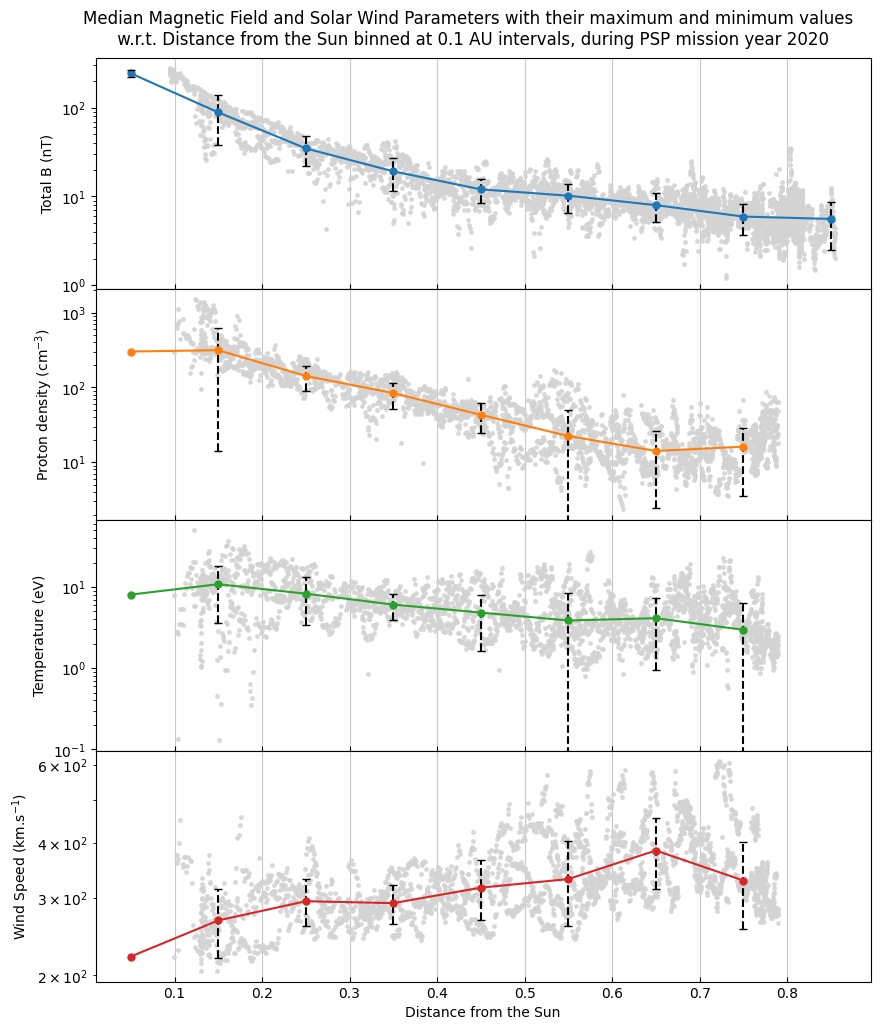

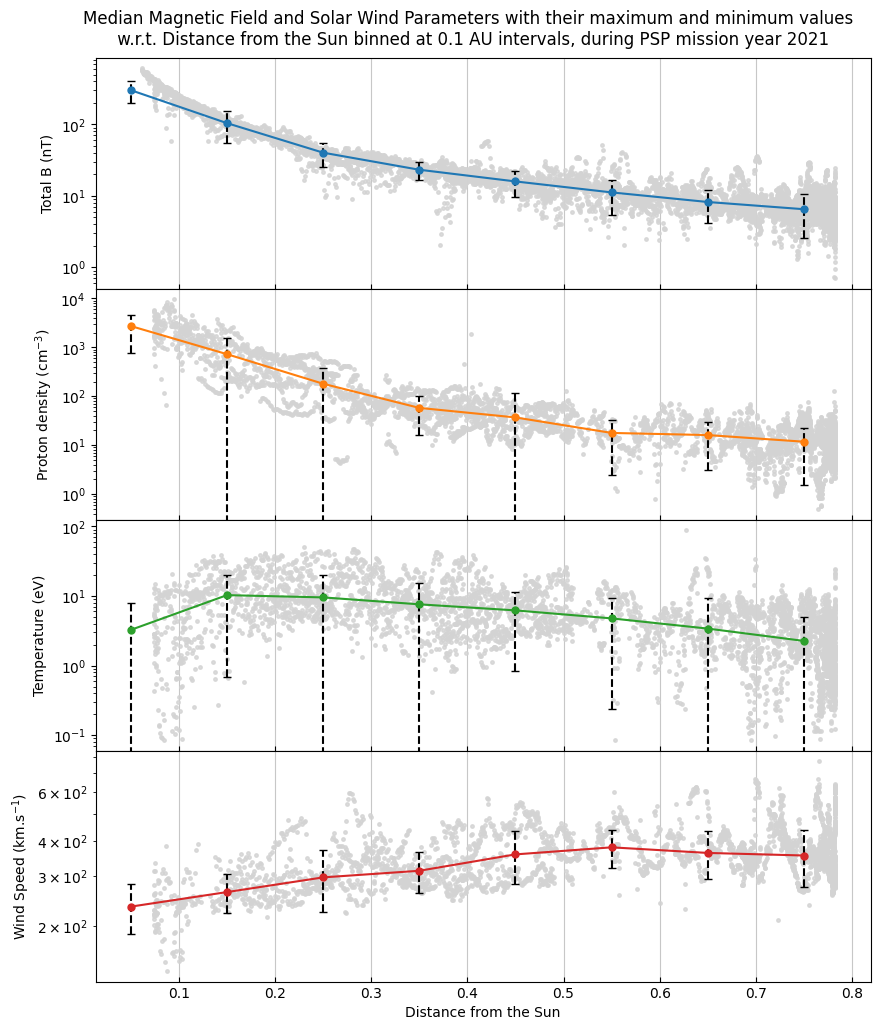

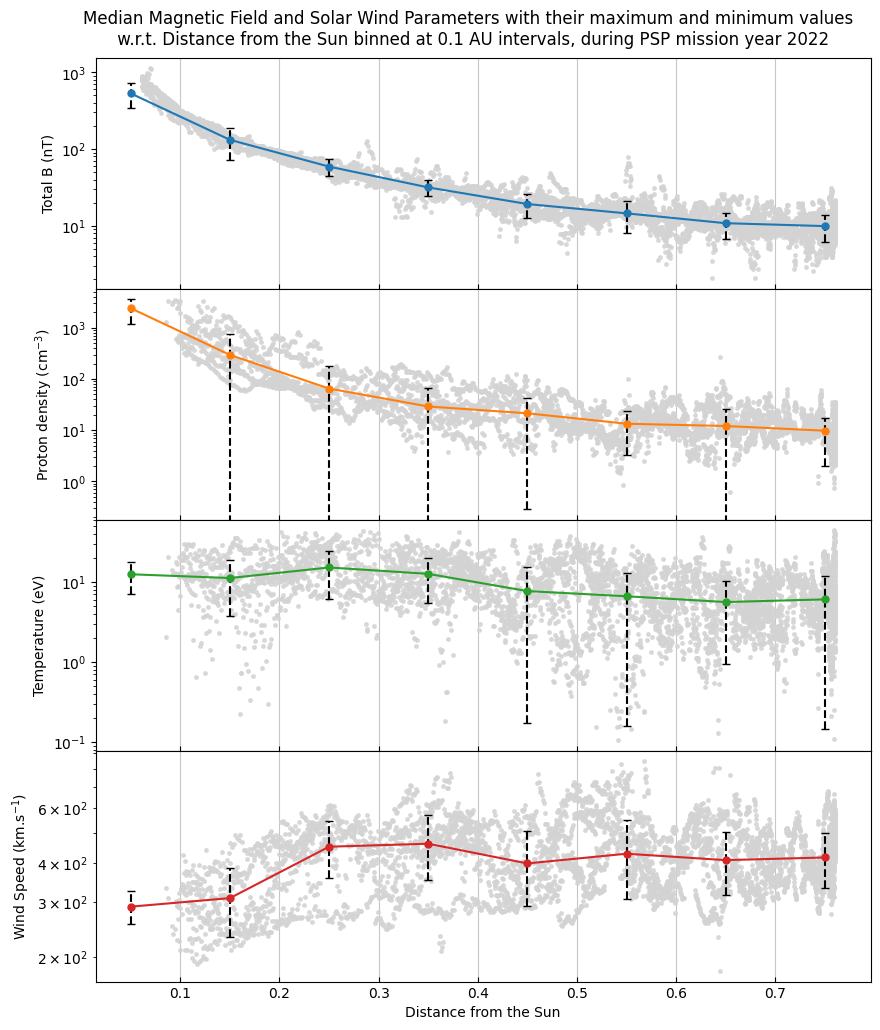

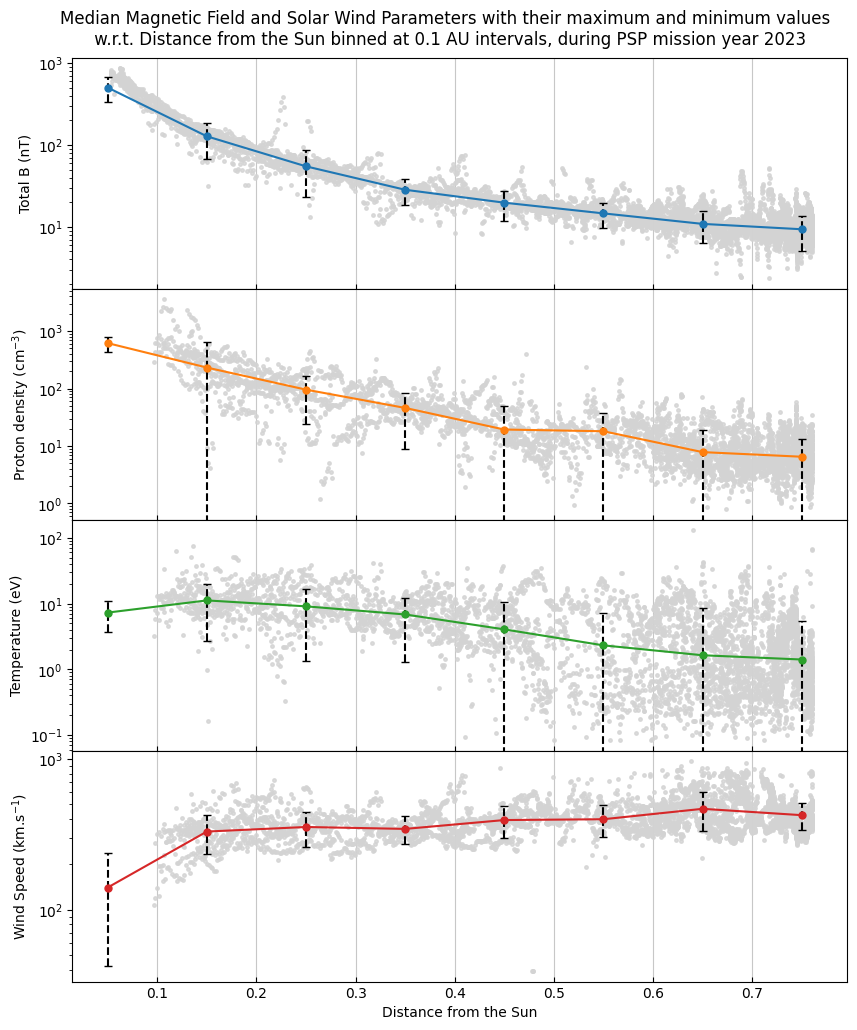

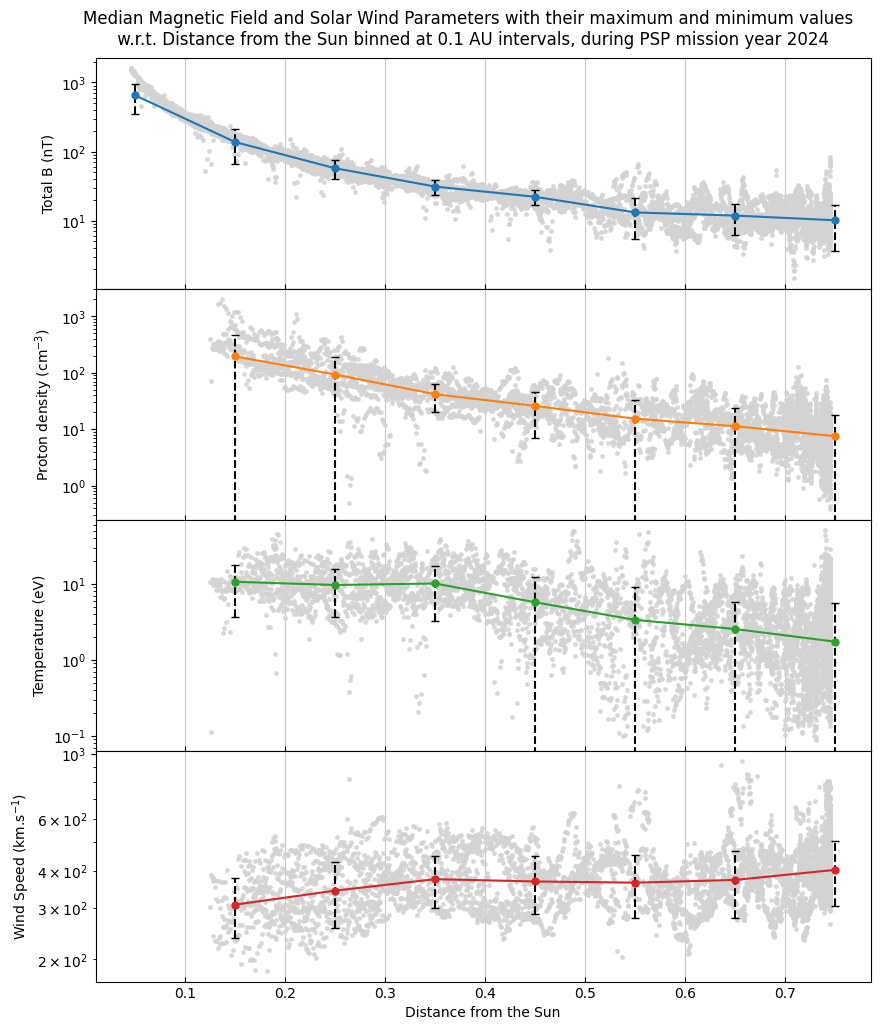

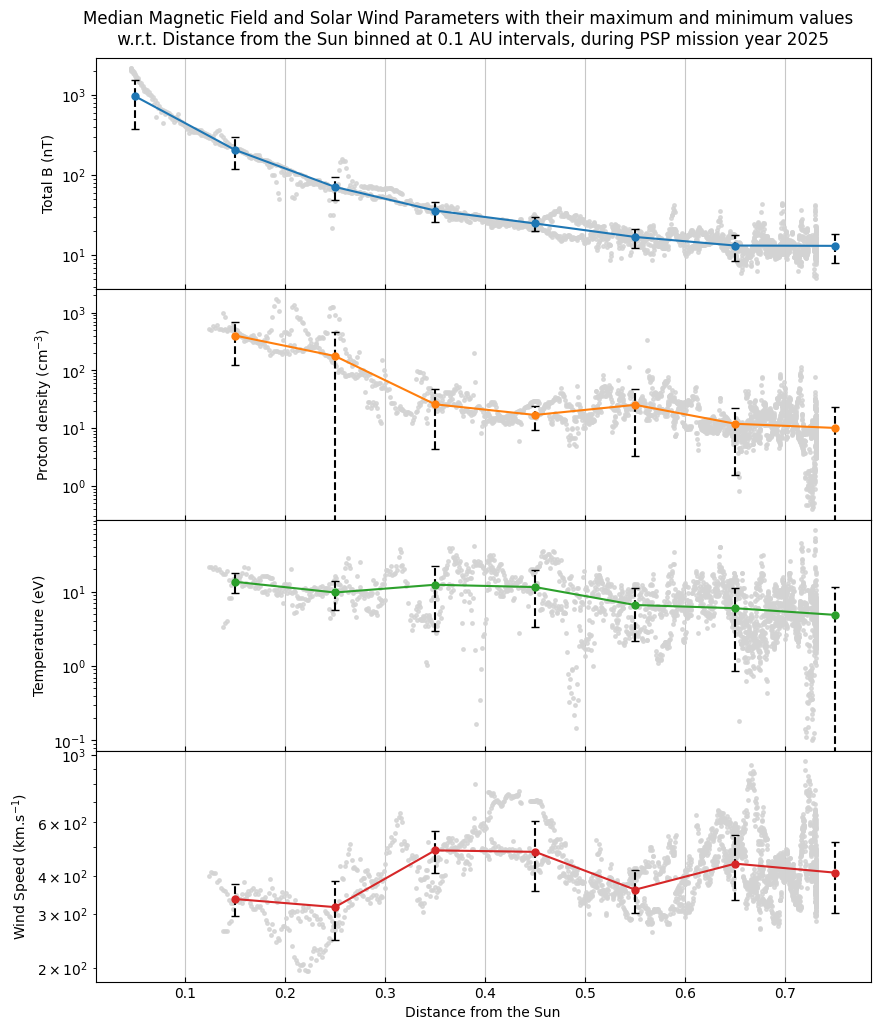

In [110]:
for year in np.arange(2020, 2026):

    # Create dataset, bin by distance
    psp = create_ds('psp', year)
    psp_bin_med, psp_bin_std = bin_distance(psp)

    colors = ['tab:blue','tab:orange','tab:green','tab:red','m','y']

    fig, ax = plt.subplots(4, sharex=True, dpi=100, figsize=(10,12))

    ax[0].set_ylabel('Total B (nT)')
    ax[1].set_ylabel('Proton density (cm$^{-3}$)')
    ax[2].set_ylabel('Temperature (eV)')
    ax[3].set_ylabel('Wind Speed (km.s$^{-1}$)')
    ax[3].set_xlabel('Distance from the Sun')

    for aa, data, color in zip(ax, ['total_B', 'Np', 'Tp', 'Vp'], colors):
        # Plot Data
        aa.plot(psp['Distance'], psp[f'{data}'], '.', c='lightgrey', ms=5, alpha=.8)

        # Stdev lines
        aa.vlines(bins[:-1]+.05, psp_bin_med[f'{data}']-psp_bin_std[f'{data}'], psp_bin_med[f'{data}']+psp_bin_std[f'{data}'], 'k', ls='--')

        # Plot Median
        aa.plot(bins[:-1]+.05, psp_bin_med[f'{data}'], '-o', c=color, ms=5)

        # Plot stdev bounds
        aa.plot(bins[:-1]+.05, psp_bin_med[f'{data}']-psp_bin_std[f'{data}'], 'k_')
        aa.plot(bins[:-1]+.05, psp_bin_med[f'{data}']+psp_bin_std[f'{data}'], 'k_')

        # Add grid, inwards ticks
        aa.tick_params(axis='x', direction='in', which='both')
        aa.grid('.', alpha=0.7, axis='x')
        aa.set_yscale('log')

    plt.subplots_adjust(hspace=0)

    #fig.suptitle(f'Median Magnetic Field and Solar Wind Parameters with their standard deviation w.r.t. Distance from \n the Sun binned at 0.1 AU intervals, between {start} and {end} (PSP, hourly-averaged data)', y=0.92)

    fig.suptitle(f'Median Magnetic Field and Solar Wind Parameters with their maximum and minimum values \n w.r.t. Distance from the Sun binned at 0.1 AU intervals, during PSP mission year {str(year)}', y=0.92)
    plt.savefig(f'plots/psp_median_params_{str(year)}.png')